# Notebook to run full analysis for a flight

## Basic imports and setup

In [ ]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package to deal with DataFrames
import pandas as pd
# Package to plot stuff
import matplotlib.pyplot as plt
# Package to make nicer plots
import seaborn as sns
# Package for numerical and array handling
import numpy as np
# Package for math stuff
import math
# Package to read and write to .sqlite files
import sqlite3
# Package to keep track of time
import datetime
# Package to decode binary data
import struct
# Package for statistical optimization
import statsmodels.api as sm
# Package for minimization
from scipy.optimize import minimize

# Function to clear output from jupyter notebook
from IPython.display import clear_output
# Package for compressing dataframes into file
from src.data import compressors
# Package for defining and fitting weather models
from src.models import weather
# Utilities package
from src.common import utils
# Package for interpolating and estimating weather
from src.analysis import weather_interpolator
# Package to handle and create plots
from src.frontend import plotter

%matplotlib inline

# Path from this notebook to the root directory
root_path = os.path.normpath(root_path)
# Path from root to the desired config file
config_path_from_root = os.path.normpath('config/config.yml')
# Defining path from this notebook to config file
config_path = os.path.join(root_path, config_path_from_root)

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)

# Defining "clear-output" function to feed into logger
def clear():
    clear_output(wait=True)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config, clear_function=None)

pltr = plotter.Plotter(config)

# Defining location of data
flights_database = '../data/flight/KLAX_KSFO_2023-01-01_2023-01-31.sqlite'
weather_database = '../data/weather/Weather-US_2022-12-31_2023-02-01.sqlite'

departure_airport = flights_database.split('/')[-1].split('_')[0]
arrival_airport = flights_database.split('/')[-1].split('_')[1]
month = flights_database.split('/')[-1].split('_')[3].split('-')[1]

flights_thresh = 100

if month == '01':
    month = 'January'
elif month == '07':
    month = 'July'

## Superficial Flights Analysis

### Number of Flights by Airline

Done


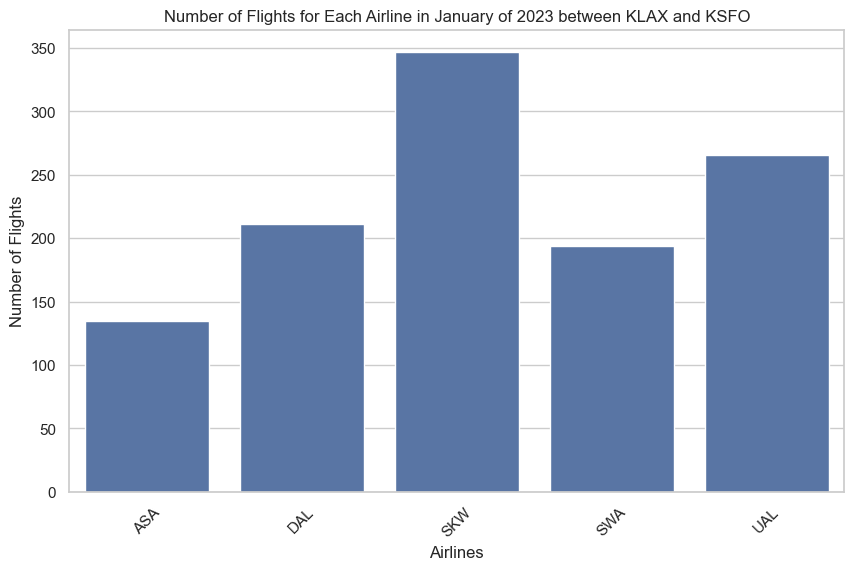

In [49]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query(f"SELECT * FROM flights", flights_connection)

flights_connection.close()

flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

airlines, counts = np.unique(flights['airline'], return_counts=True)

mask = counts > flights_thresh
airlines = airlines[mask]
counts = counts[mask]

data = pd.DataFrame({
    'Airlines': airlines,
    'Flight Counts': counts
})

# Creating the plot using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Airlines', y='Flight Counts', data=data, ax=ax)
ax.set_title(f'Number of Flights for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Airlines')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

print("Done")

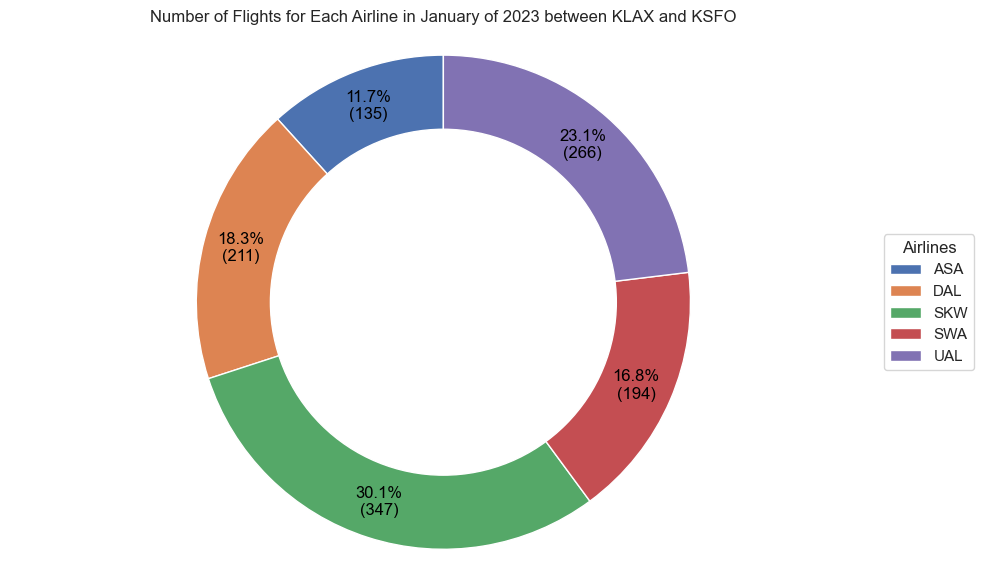

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Connect to your flights database
flights_connection = sqlite3.connect(flights_database)

# Fetch data from the 'flights' table
flights = pd.read_sql_query("SELECT * FROM flights", flights_connection)

# Close the database connection
flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts = np.unique(flights['airline'], return_counts=True)

mask = counts > flights_thresh
airlines = airlines[mask]
counts = counts[mask]

# Create a DataFrame from the data
data = pd.DataFrame({
    'Airlines': airlines,
    'Flight Counts': counts
})

# Creating the pie chart using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))

def custom_autopct(pct):
    total = sum(counts)
    val = int(round(pct*total/100.0))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val) if pct > 3 else ''

wedges, texts, autotexts = ax.pie(data['Flight Counts'], autopct=custom_autopct,
                                   startangle=90, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Change the color and position of the percentage texts
for autotext in autotexts:
    autotext.set_color('black')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Create a legend
ax.legend(wedges, data['Airlines'], title="Airlines", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title(f'Number of Flights for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Display the plot
plt.tight_layout()
plt.show()


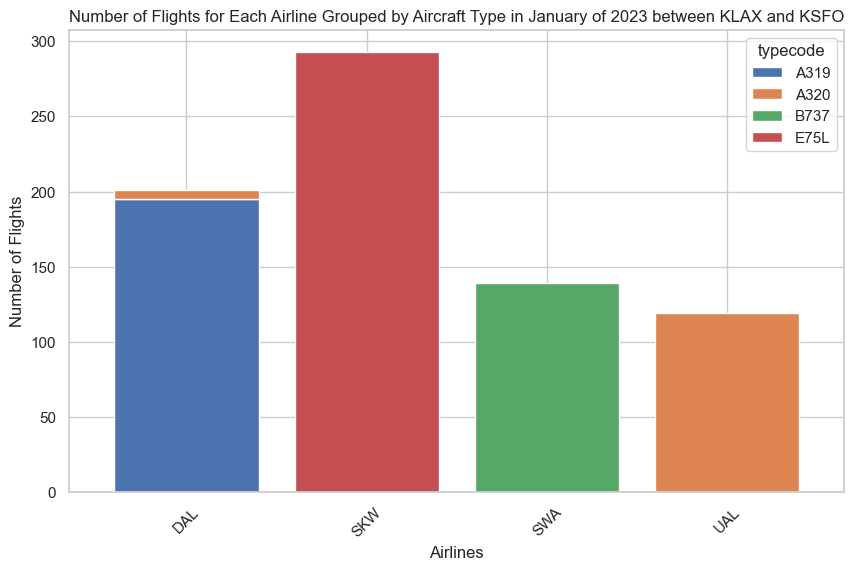

Done


In [55]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT * FROM flights 
    JOIN flights_aircraft ON flights_aircraft.icao24 = flights.icao24
    """, flights_connection)

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts = np.unique(flights['airline'], return_counts=True)

mask = counts > flights_thresh
airlines = airlines[mask]
counts = counts[mask]

flights = flights[flights['airline'].apply(lambda x: x in airlines)]

aircrafts, counts = np.unique(flights['typecode'], return_counts=True)

mask = counts > flights_thresh
aircrafts = aircrafts[mask]
counts = counts[mask]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]

# Group by airlines and aircraft type, then count
grouped_data = flights.groupby(['airline', 'typecode']).size().reset_index(name='counts')

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='airline', columns='typecode', values='counts').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title(f'Number of Flights for Each Airline Grouped by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Airlines')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.show()

print("Done")


### Number of Flights by Aircraft

Done


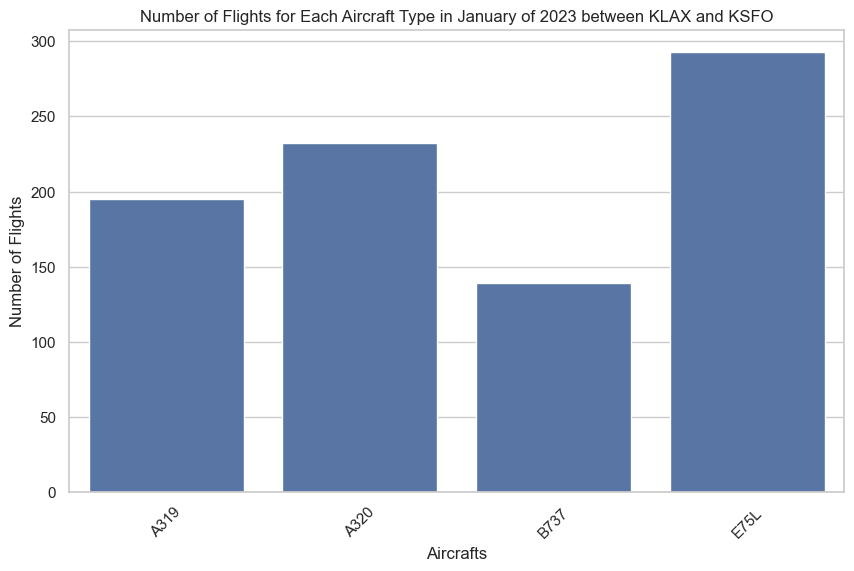

In [63]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query(f"SELECT * FROM flights JOIN flights_aircraft ON flights_aircraft.icao24 = flights.icao24", flights_connection)

flights_connection.close()

flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

data = pd.DataFrame({
    'Aircrafts': aircrafts,
    'Flight Counts': counts_aircrafts
})

# Creating the plot using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Aircrafts', y='Flight Counts', data=data, ax=ax)
ax.set_title(f'Number of Flights for Each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Aircrafts')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

print("Done")

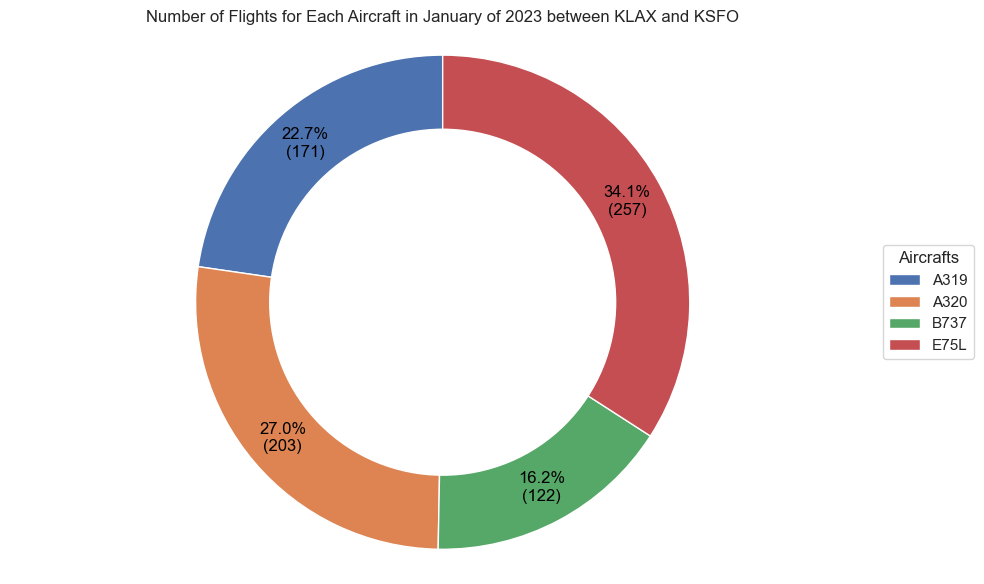

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Connect to your flights database
flights_connection = sqlite3.connect(flights_database)

# Fetch data from the 'flights' table
flights = pd.read_sql_query(f"SELECT * FROM flights JOIN flights_aircraft ON flights_aircraft.icao24 = flights.icao24", flights_connection)

# Close the database connection
flights_connection.close()

# Extract aicraft codes from callsigns
flights['airline'] = flights['typecode'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Create a DataFrame from the data
data = pd.DataFrame({
    'Aircrafts': aircrafts,
    'Flight Counts': counts_aircrafts
})

# Creating the pie chart using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))

def custom_autopct(pct):
    total = sum(counts)
    val = int(round(pct*total/100.0))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val) if pct > 3 else ''

wedges, texts, autotexts = ax.pie(data['Flight Counts'], autopct=custom_autopct,
                                   startangle=90, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Change the color and position of the percentage texts
for autotext in autotexts:
    autotext.set_color('black')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Create a legend
ax.legend(wedges, data['Aircrafts'], title="Aircrafts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title(f'Number of Flights for Each Aircraft in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Display the plot
plt.tight_layout()
plt.show()


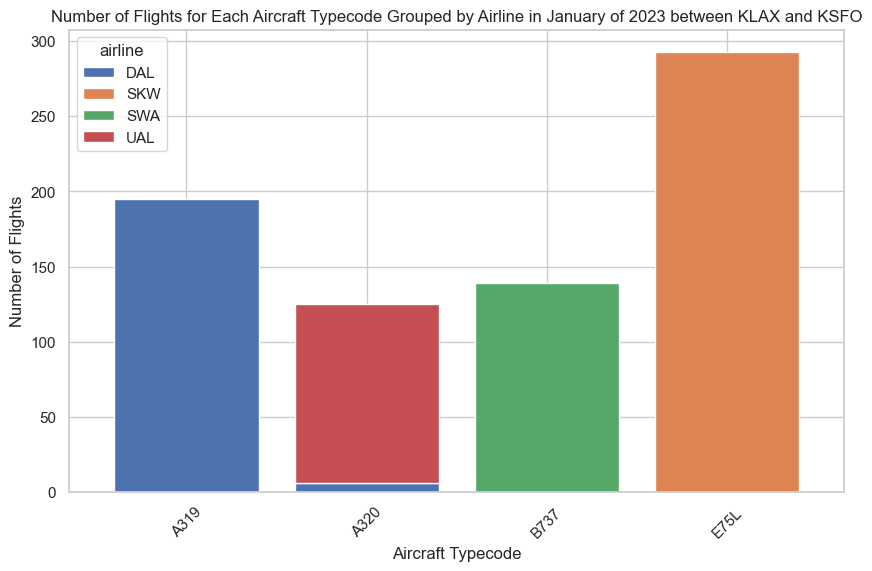

Done


In [65]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT * FROM flights 
    JOIN flights_aircraft ON flights_aircraft.icao24 = flights.icao24
    """, flights_connection)

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Group by typecode and airline, then count
grouped_data = flights.groupby(['typecode', 'airline']).size().reset_index(name='counts')

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='typecode', columns='airline', values='counts').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title(f'Number of Flights for Each Aircraft Typecode Grouped by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Aircraft Typecode')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.show()

print("Done")


## Fuel Consumption Analysis

### Fuel Consumption by Airline

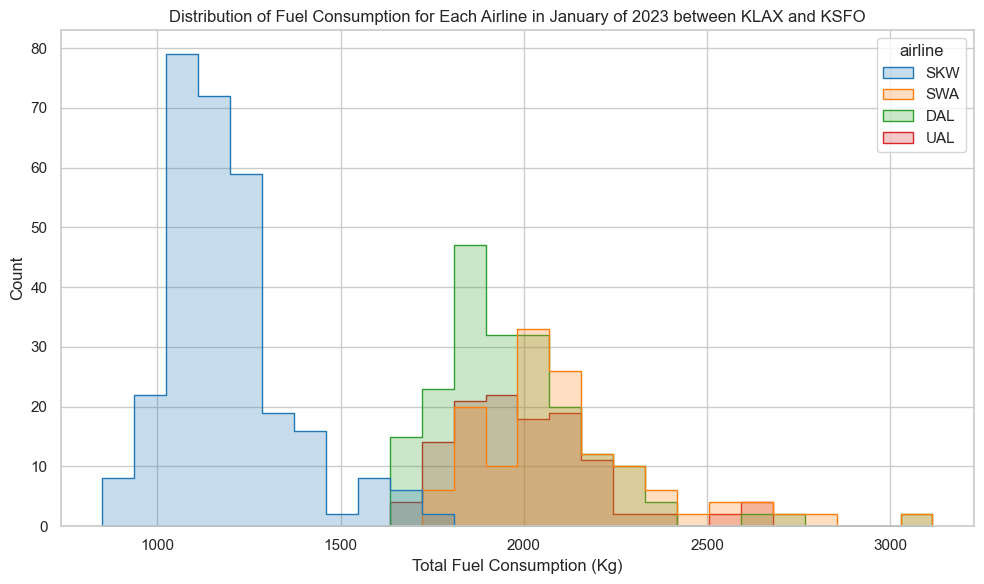

In [66]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define the number of bins
bins = np.linspace(flights['fuel'].min(), flights['fuel'].max(), num=int(np.sqrt(len(flights))))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=flights, x='fuel', hue='airline', element='step', stat='count', common_norm=False, bins=bins, palette='tab10', ax=ax)

# Labeling the plot
ax.set_xlabel('Total Fuel Consumption (Kg)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Fuel Consumption for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show legend and plot
fig.tight_layout()

plt.show()

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/1396182004.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='airline', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_airlines)
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/1396182004.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.violinplot(x='airline', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_airlines)


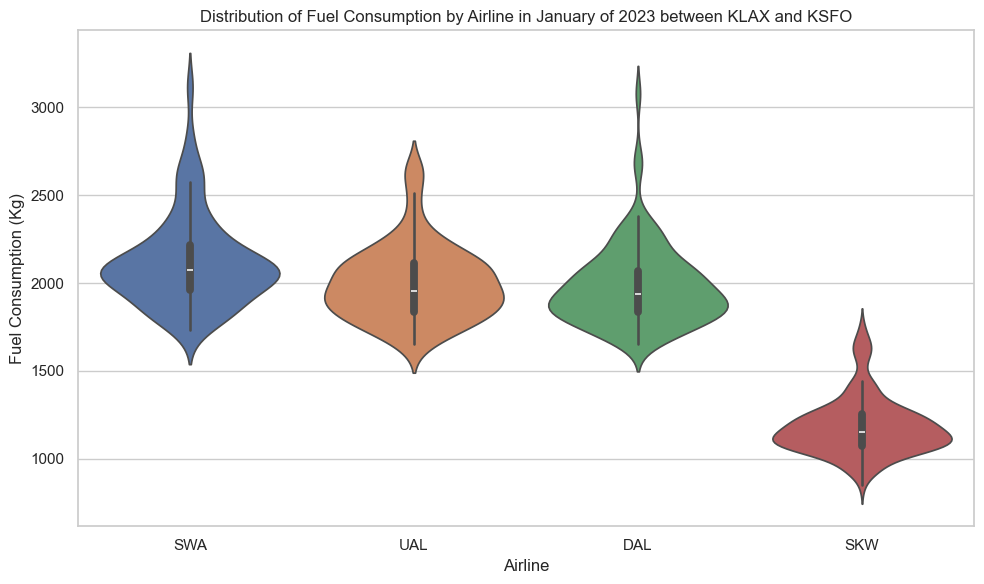

In [67]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create the violin plot using the axes object with sorted data
sns.violinplot(x='airline', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_airlines)

# Labeling the plot
ax.set_xlabel('Airline')
ax.set_ylabel('Fuel Consumption (Kg)')
ax.set_title(f'Distribution of Fuel Consumption by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/1891769607.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_fuel_by_airline.values, y=average_fuel_by_airline.index, ax=ax,


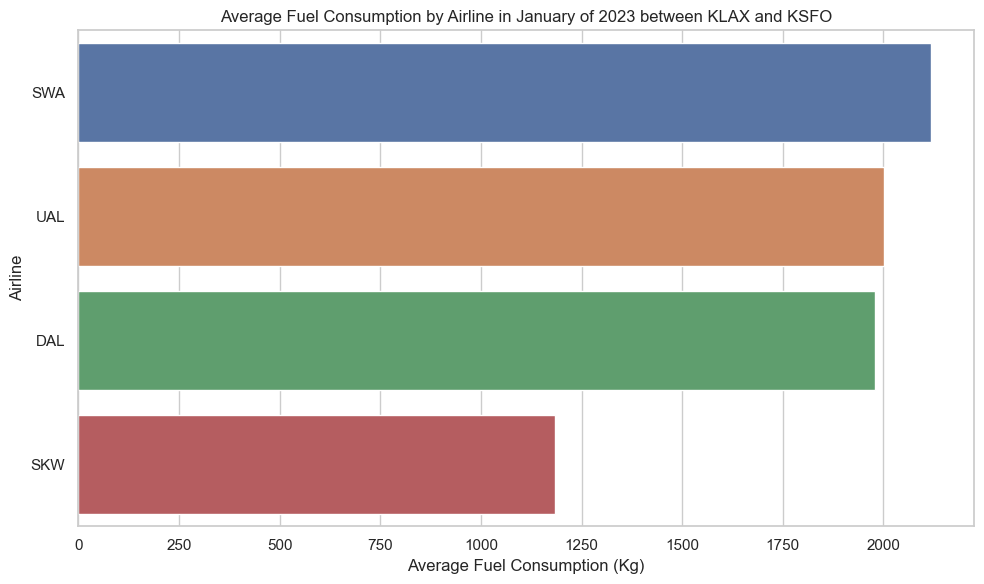

In [68]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each airline to ensure consistent coloring
unique_airlines = average_fuel_by_airline.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_airlines)}
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot with consistent colors
sns.barplot(x=average_fuel_by_airline.values, y=average_fuel_by_airline.index, ax=ax, 
            palette=[colors[airline] for airline in average_fuel_by_airline.index])

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Airline')
ax.set_title(f'Average Fuel Consumption by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption by Aircraft

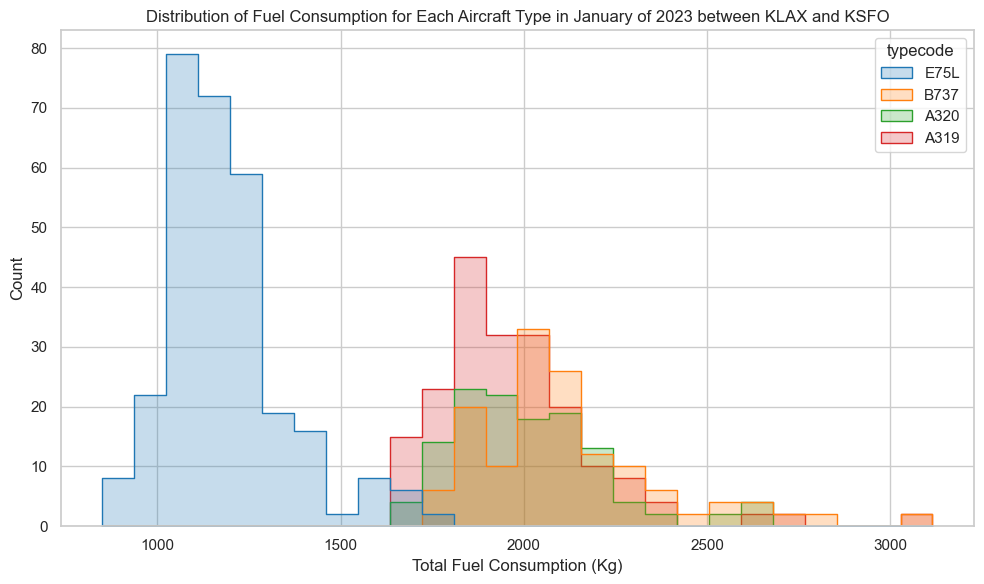

In [69]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define the number of bins
bins = np.linspace(flights['fuel'].min(), flights['fuel'].max(), num=int(np.sqrt(len(flights))))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=flights, x='fuel', hue='typecode', element='step', stat='count', common_norm=False, bins=bins, palette='tab10', ax=ax)

# Labeling the plot
ax.set_xlabel('Total Fuel Consumption (Kg)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Fuel Consumption for Each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show legend and plot
fig.tight_layout()

plt.show()

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/4029497284.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='typecode', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_aircrafts)
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/4029497284.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.violinplot(x='typecode', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_aircrafts)


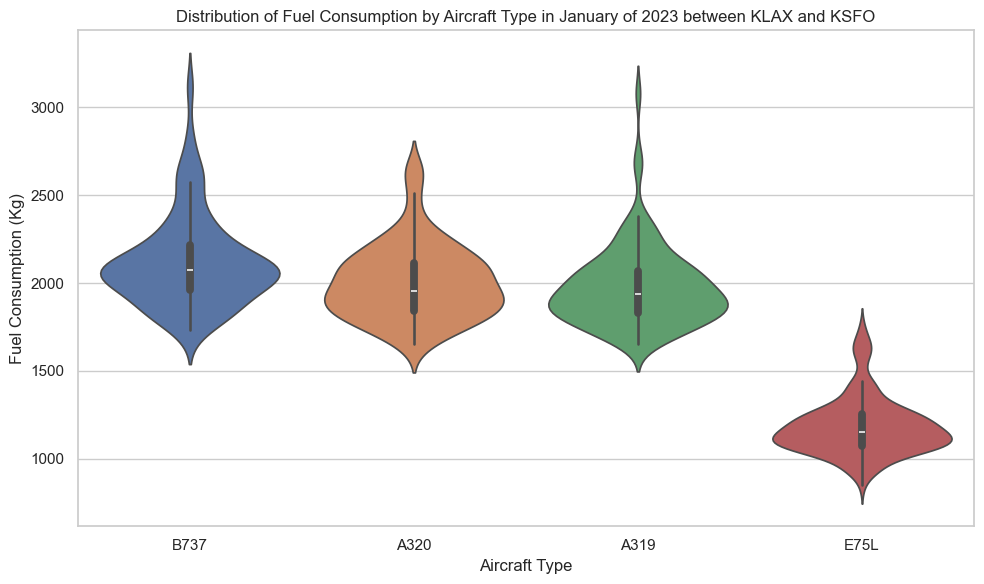

In [70]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by aircraft type
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order of aircraft types
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create the violin plot using the axes object with sorted data
sns.violinplot(x='typecode', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_aircrafts)

# Labeling the plot
ax.set_xlabel('Aircraft Type')
ax.set_ylabel('Fuel Consumption (Kg)')
ax.set_title(f'Distribution of Fuel Consumption by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_31984/543500935.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_fuel_by_aircraft.values, y=average_fuel_by_aircraft.index, ax=ax,


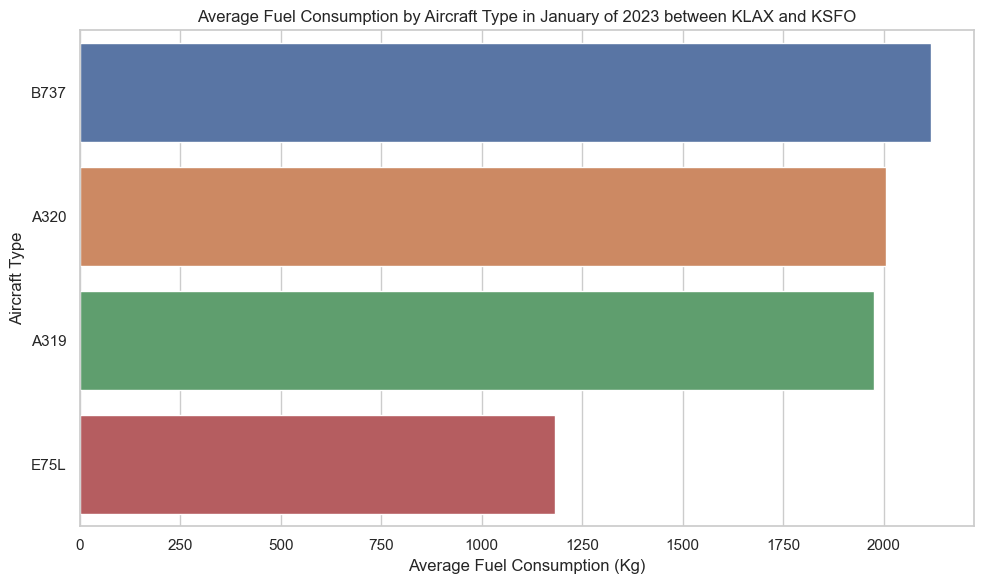

In [71]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by aircraft
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each aircraft to ensure consistent coloring
unique_aircrafts = average_fuel_by_aircraft.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_aircrafts)}
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot with consistent colors
sns.barplot(x=average_fuel_by_aircraft.values, y=average_fuel_by_aircraft.index, ax=ax, 
            palette=[colors[aircraft] for aircraft in average_fuel_by_aircraft.index])

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Aircraft Type')
ax.set_title(f'Average Fuel Consumption by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

## Fuel Consumption Vs Time

### Fuel Consumption Vs Time By Airline

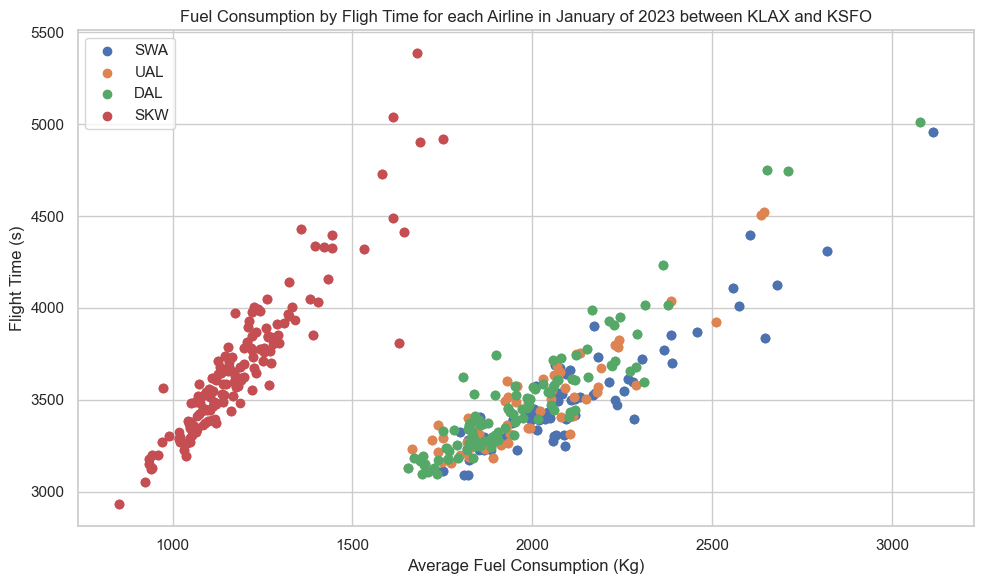

In [72]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])
# Decodes time
flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for airline in sorted_airlines:
    mask = flights['airline'] == airline
    ax.scatter(flights[mask]['fuel'], flights[mask]['time'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Time (s)')
ax.set_title(f'Fuel Consumption by Fligh Time for each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption Vs Time By Aircraft

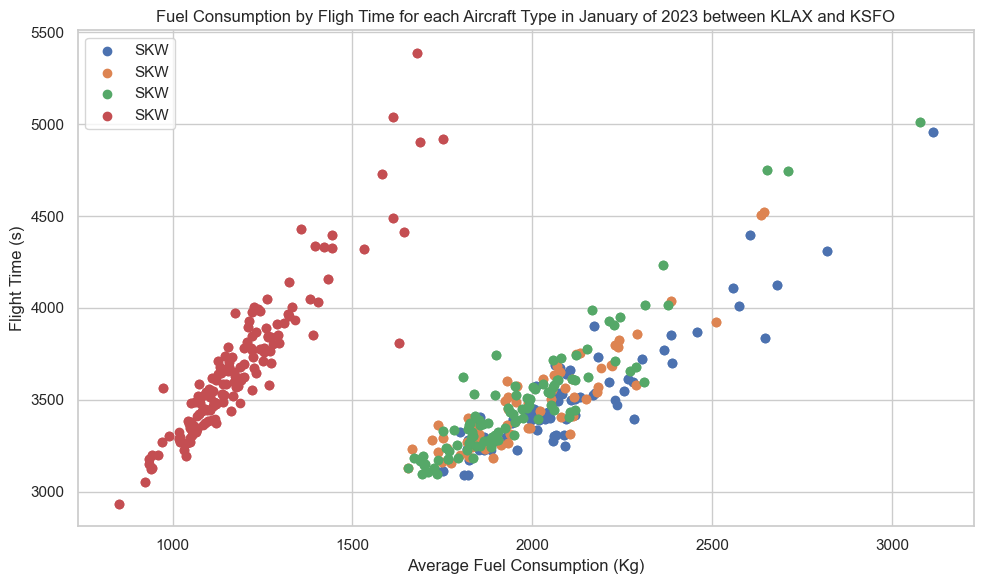

In [73]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])
# Decodes time
flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for aircraft in sorted_aircrafts:
    mask = flights['typecode'] == aircraft
    ax.scatter(flights[mask]['fuel'], flights[mask]['time'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Time (s)')
ax.set_title(f'Fuel Consumption by Fligh Time for each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

## Fuel Consumption Vs Distance

### Fuel Consumption Vs Distance By Airline

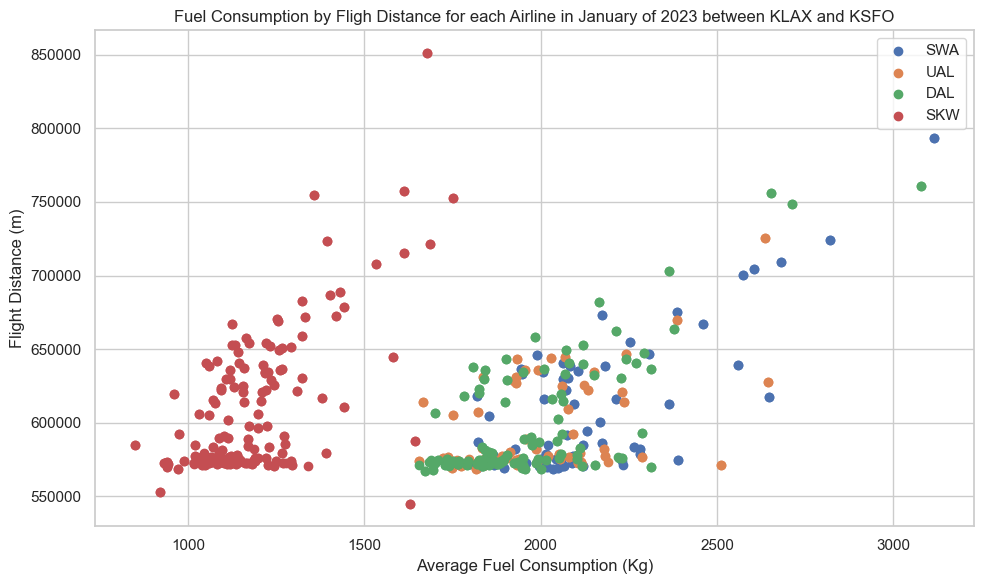

In [74]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for airline in sorted_airlines:
    mask = flights['airline'] == airline
    ax.scatter(flights[mask]['fuel'], flights[mask]['distance'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Distance (m)')
ax.set_title(f'Fuel Consumption by Fligh Distance for each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption Vs Distance By Airline

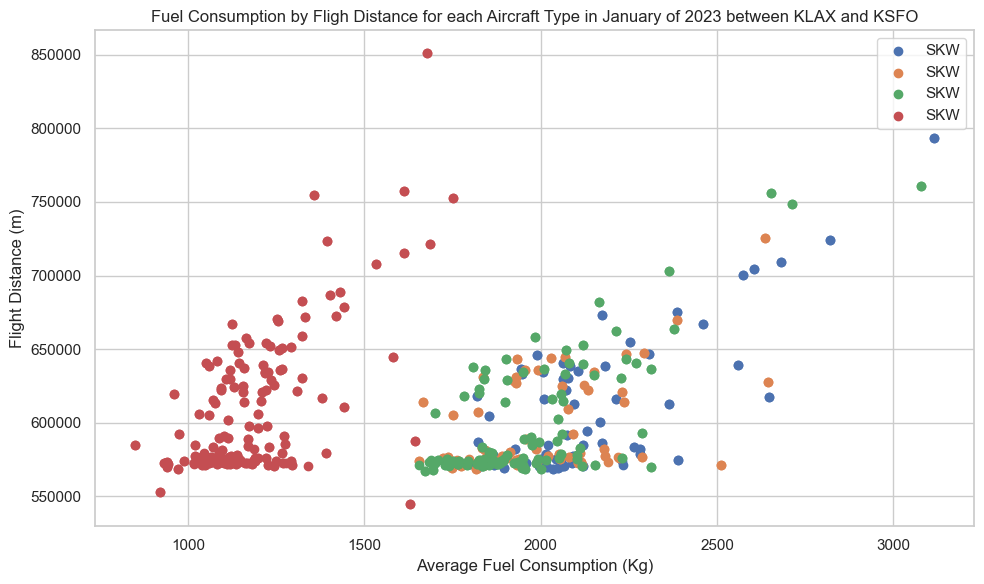

In [75]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT *
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    """, flights_connection).dropna()

flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for aircraft in sorted_aircrafts:
    mask = flights['typecode'] == aircraft
    ax.scatter(flights[mask]['fuel'], flights[mask]['distance'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Distance (m)')
ax.set_title(f'Fuel Consumption by Fligh Distance for each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()

# Show plot
fig.tight_layout()
plt.show()

## Weather Integrals

### Optimal Vs Actual

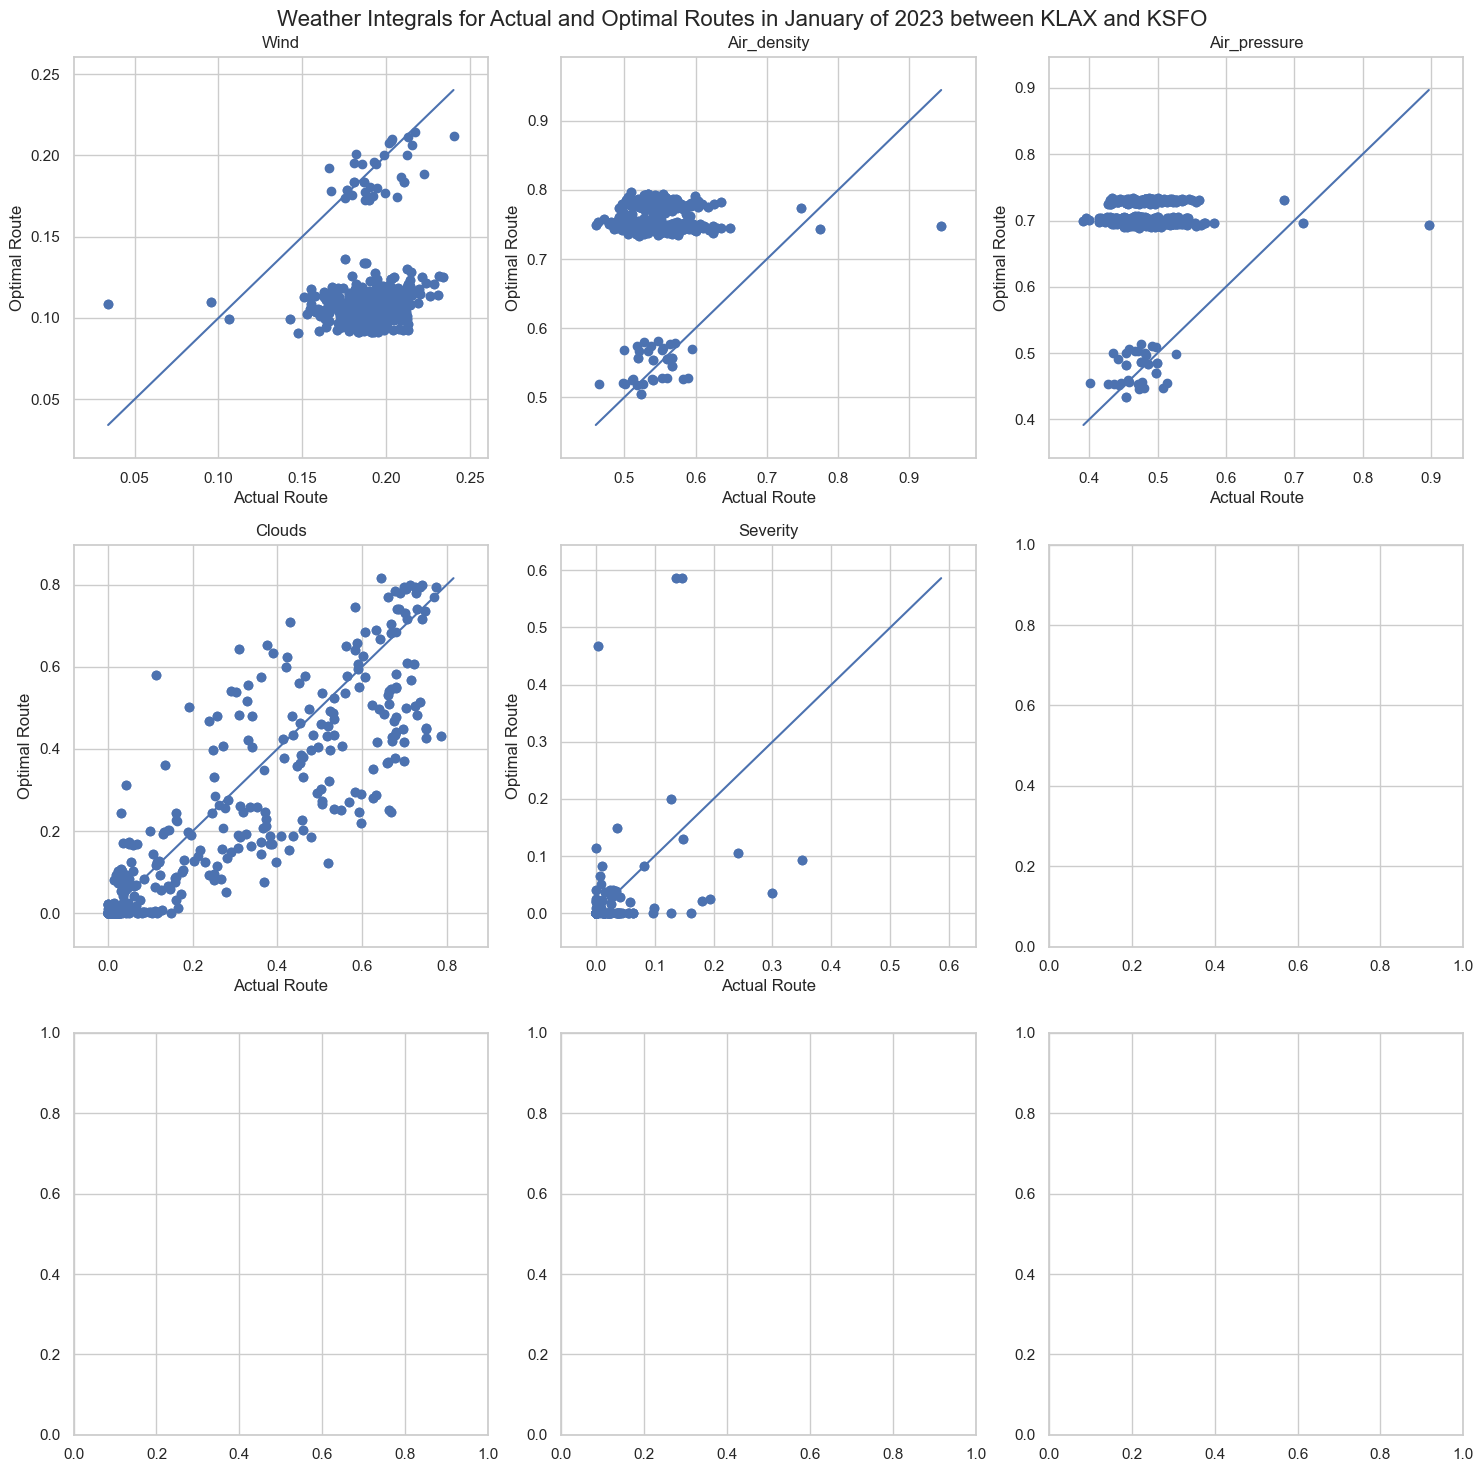

In [76]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection).dropna()
flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])
# Decodes time
flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])
flights['opt_time'] = flights['opt_time'].apply(lambda x: struct.unpack('Q', x)[0])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
opt_columns = ['opt_'+col for col in columns]

grid_size = math.ceil(np.sqrt(len(columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()
for i, col, opt_col in zip(range(len(columns)), columns, opt_columns):
    ax = axes[i]
    minX = min([flights[col].min(), flights[opt_col].min()])
    maxX = max([flights[col].max(), flights[opt_col].max()])
    rangeX = maxX - minX
    ax.scatter(flights[col], flights[opt_col])
    ax.plot([minX, maxX], [minX, maxX])
    ax.set_xlabel('Actual Route')
    ax.set_ylabel('Optimal Route')
    ax.set_title(f'{col[0].upper()}{col[1:]}')

    ax.set_xlim([minX - rangeX*0.1, maxX + rangeX*0.1])
    ax.set_ylim([minX - rangeX*0.1, maxX + rangeX*0.1])
    
fig.suptitle(f'Weather Integrals for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

fig.tight_layout()

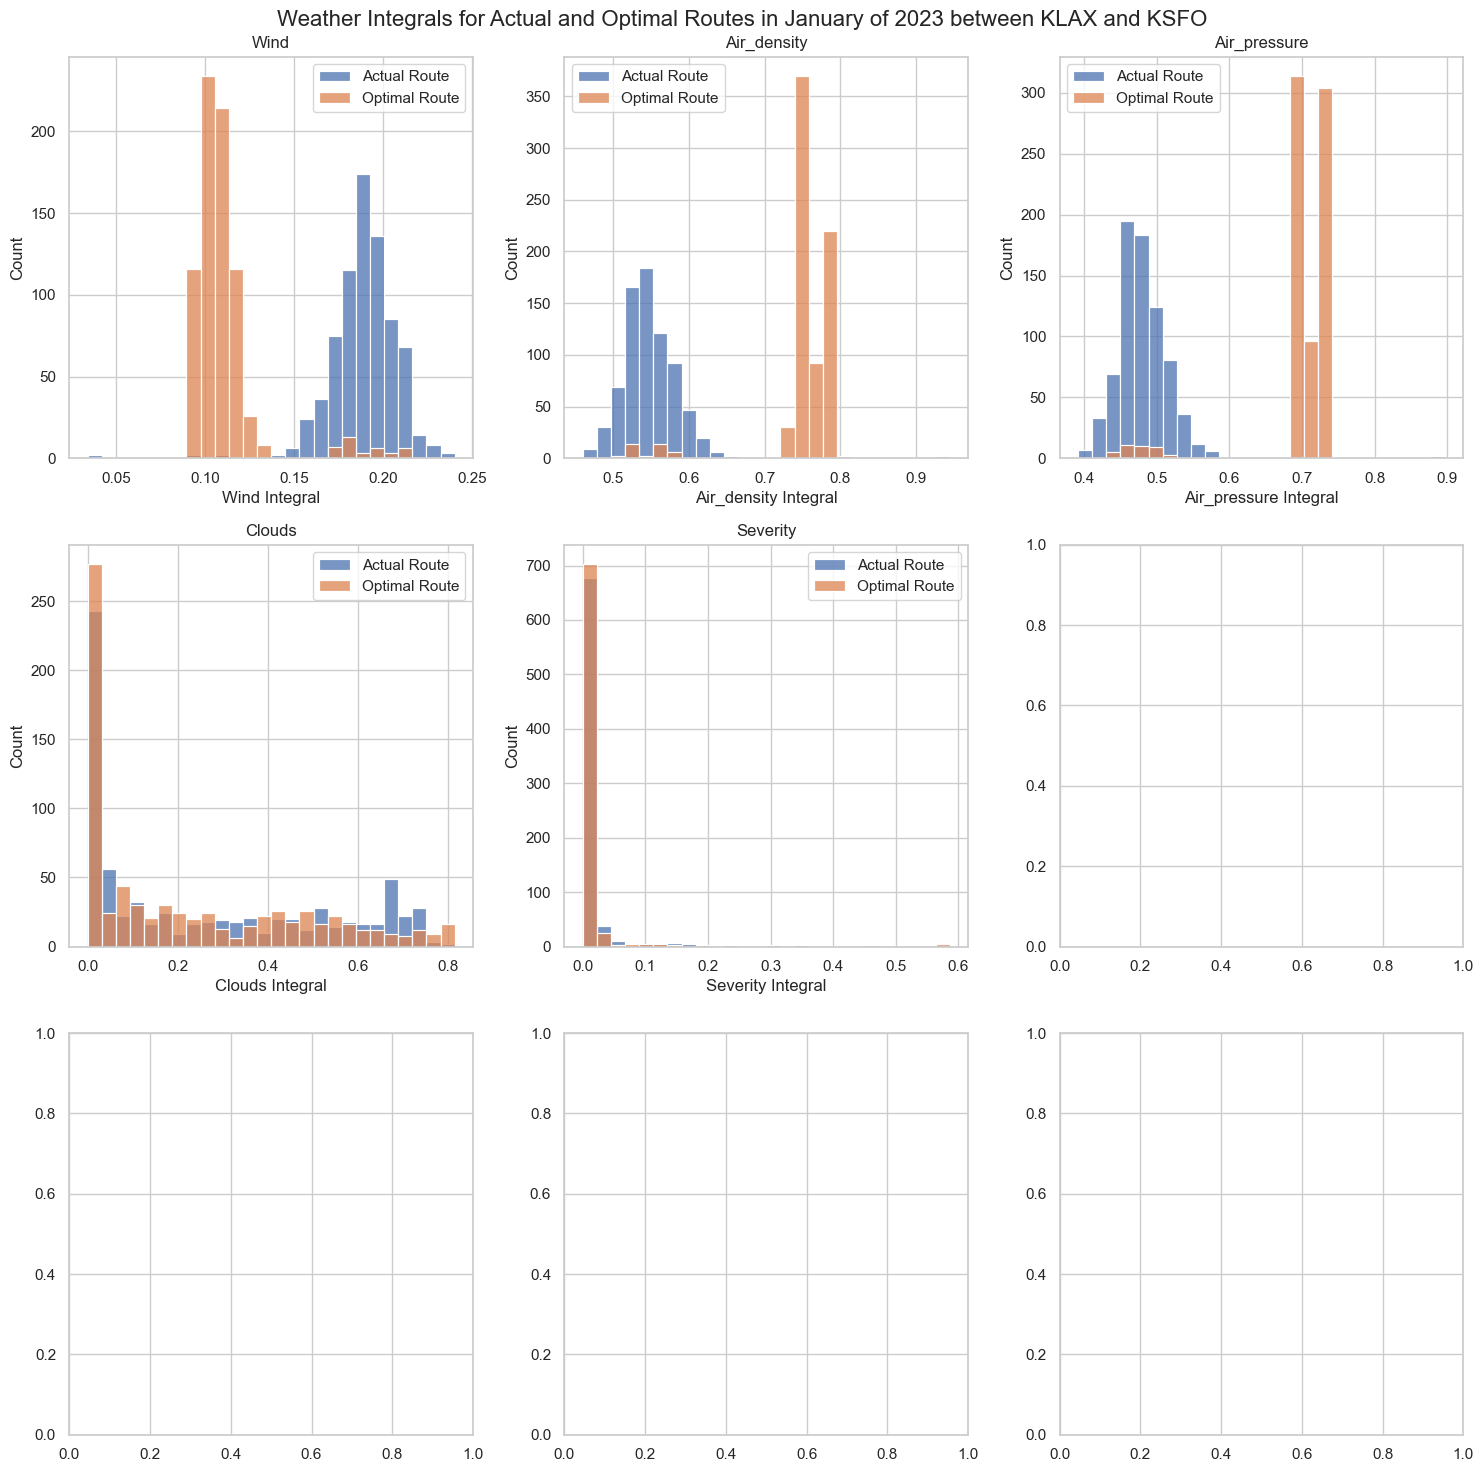

In [77]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection).dropna()
flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])
# Decodes time
flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])
flights['opt_time'] = flights['opt_time'].apply(lambda x: struct.unpack('Q', x)[0])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
opt_columns = ['opt_'+col for col in columns]

grid_size = math.ceil(np.sqrt(len(columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()
for i, col, opt_col in zip(range(len(columns)), columns, opt_columns):
    ax = axes[i]
    minX = min([flights[col].min(), flights[opt_col].min()])
    maxX = max([flights[col].max(), flights[opt_col].max()])
    rangeX = maxX - minX
    bins = np.linspace(minX, maxX, num=int(np.sqrt(len(flights))))
    sns.histplot(flights[col], bins=bins, kde=False, label='Actual Route', ax=ax)
    sns.histplot(flights[opt_col], bins=bins, kde=False, label='Optimal Route', ax=ax)
    
    
    ax.set_xlabel(f'{col[0].upper()}{col[1:]} Integral')
    ax.set_ylabel('Count')
    ax.set_title(f'{col[0].upper()}{col[1:]}')
    ax.legend()
    
fig.suptitle(f'Weather Integrals for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

fig.tight_layout()

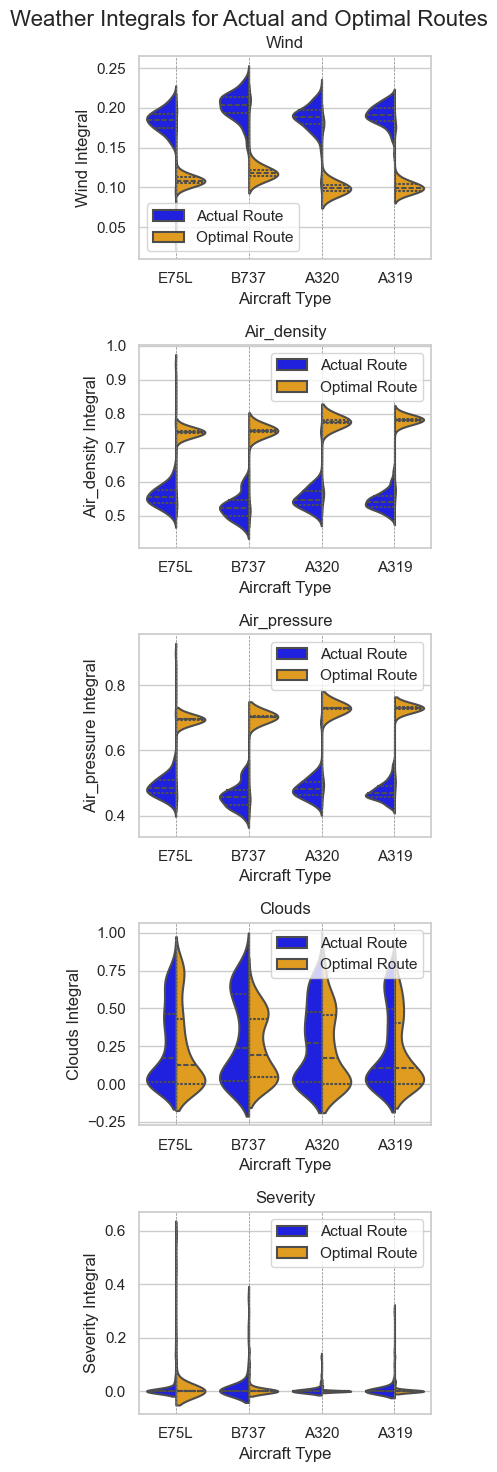

In [78]:
df_melted = pd.melt(flights,
                    id_vars='typecode',
                    value_vars=columns + opt_columns,
                    var_name='condition',
                    value_name='value')
condition_mapping = {**{col: 'Actual Route' for col in columns}, **{opt_col: 'Optimal Route' for opt_col in opt_columns}}
df_melted['Route'] = df_melted['condition'].map(condition_mapping)

# Create a mapping from each column name to the route type ('Actual' or 'Optimal')
route_type_mapping = {col: 'Actual Route' for col in columns}
route_type_mapping.update({'opt_' + col: 'Optimal Route' for col in columns})

# Apply this mapping to create a new 'Route Type' column for coloring
df_melted['Route Type'] = df_melted['condition'].map(route_type_mapping)

# Now plot the violin plots
fig, axes = plt.subplots(len(columns), figsize=(len(np.unique(flights['typecode']))*1, len(columns)*3))

for i, col in enumerate(columns):
    # Filter the data for the current column and its optimal counterpart
    df_violin = df_melted[(df_melted['condition'] == col) | (df_melted['condition'] == 'opt_' + col)].copy()
    
    # Map the 'condition' to 'Actual' or 'Optimal'
    df_violin['Route Type'] = df_violin['condition'].map(lambda x: 'Actual Route' if x == col else 'Optimal Route')
    
    # Plot split violinplot
    sns.violinplot(data=df_violin, x='typecode', y='value', hue='Route Type', split=True,
               inner='quart', linewidth=1.5, palette={'Actual Route': 'blue', 'Optimal Route': 'orange'},
               density_norm='width',  # Updated parameter as per the warning
               ax=axes[i])
    
    # Get the current x-axis tick locations which should correspond to the 'typecode' categories
    xticks = axes[i].get_xticks()
    
    # Draw a vertical line at each x-axis tick location to separate the blue and orange sides
    for x in xticks:
        axes[i].axvline(x=x, color='grey', linestyle='--', lw=0.5)
    # Set the aesthetics for the plot
    axes[i].set_xlabel('Aircraft Type')
    axes[i].set_ylabel(f'{col.capitalize()} Integral')
    axes[i].set_title(f'{col.capitalize()}')

    axes[i].legend()

# Adjust the layout
plt.suptitle('Weather Integrals for Actual and Optimal Routes', fontsize=16)
fig.tight_layout()  # Adjust the rectangle in which to fit the subplots
plt.show()

# Models Optimization for Fuel Consumption and Weather Inflience Score

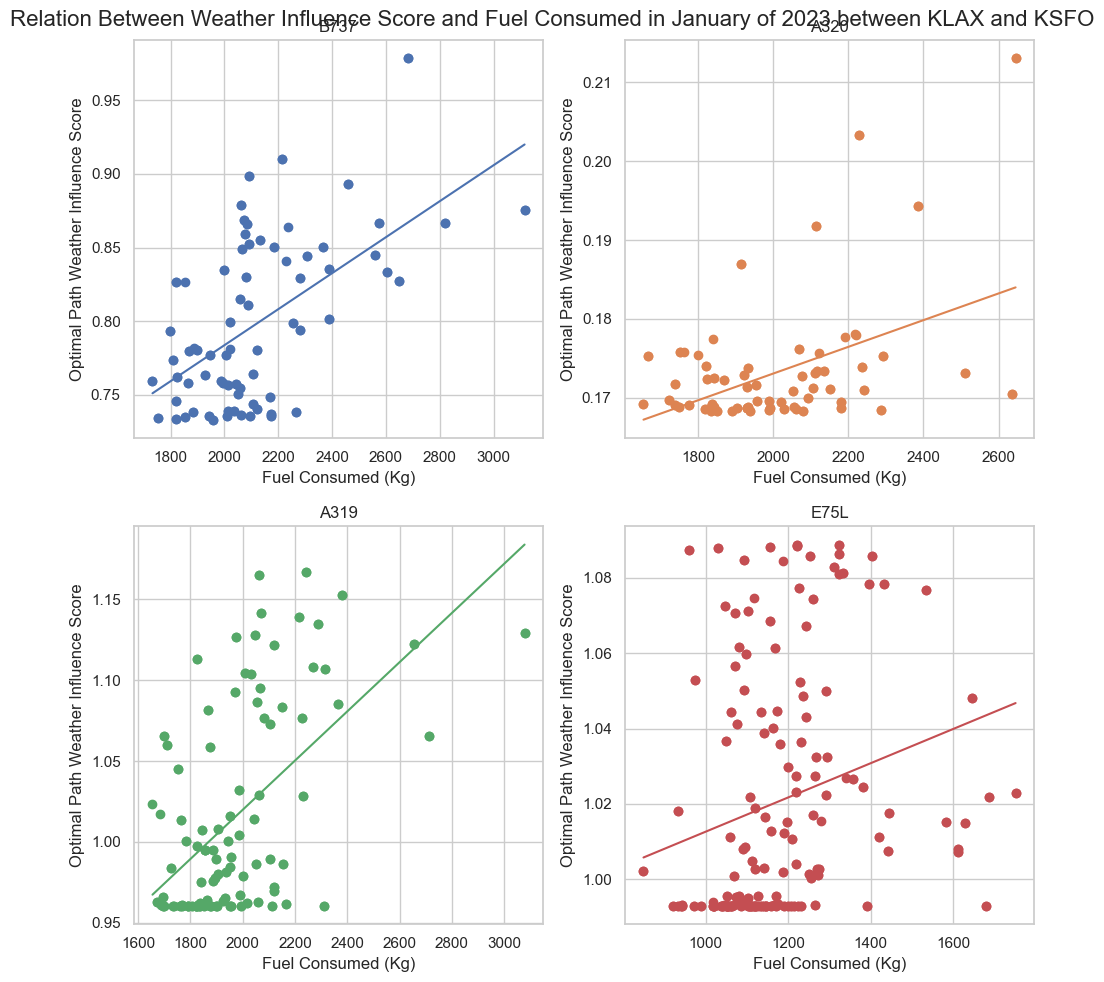

In [81]:
flights_connection = sqlite3.connect(flights_database)

flights = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection).dropna()
flights_connection.close()

# Extract airline codes from callsigns
flights['airline'] = flights['callsign'].apply(lambda x: x[:3])
# Decodes time
flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])
flights['opt_time'] = flights['opt_time'].apply(lambda x: struct.unpack('Q', x)[0])

# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

mask_airlines = (counts_airlines > flights_thresh)
mask_aircrafts = (counts_aircrafts > flights_thresh)

airlines = airlines[mask_airlines]
aircrafts = aircrafts[mask_aircrafts]

counts_airlines = counts_airlines[mask_airlines]
counts_aircrafts = counts_aircrafts[mask_aircrafts]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]
flights = flights[flights['airline'].apply(lambda x: x in airlines)]

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
# columns = ['wind', 'air_pressure', 'clouds']
opt_columns = ['opt_'+col for col in columns]
scaled_columns = [col + '_scaled' for col in columns]
opt_scaled_columns = [col + '_scaled' for col in opt_columns]

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each aircraft to ensure consistent coloring
unique_aircrafts = average_fuel_by_aircraft.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_aircrafts)}

n_aircrafts = len(sorted_aircrafts)
# Determine the number of rows and columns for the square (or nearly square) grid
grid_size = math.ceil(np.sqrt(n_aircrafts))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, aircraft in enumerate(sorted_aircrafts):
    if i >= len(axes):  # In case of more aircraft types than grid cells
        break

    ax = axes[i]
    mask = flights['typecode'] == aircraft
    flights_aircraft = flights[mask].copy()
    X = flights_aircraft[opt_columns]
    y = flights_aircraft['fuel']

    # Define the objective function: sum of squared residuals
    def objective_function(coeffs):
        predictions = X.dot(coeffs[:-1]) + coeffs[-1]  # Last coefficient is the intercept
        residuals = y - predictions
        return sum(residuals**2)

    # Define bounds for the coefficients
    bounds = []
    for col in opt_columns:
        if col in ['opt_wind', 'clouds', 'opt_severity']:
            bounds.append((0, None))  # Strictly positive
        elif col in ['opt_air_density', 'opt_air_pressure']:
            bounds.append((None, 0))  # Strictly negative
        else:
            bounds.append((None, None))  # No bounds

    # Add bounds for the intercept (last coefficient)
    bounds.append((None, None))

    # Initial guess for coefficients
    initial_guess = [0] * (len(opt_columns) + 1)

    # Perform the optimization
    result = minimize(objective_function, initial_guess, bounds=bounds)
    
    norm = np.sqrt(np.sum(result.x**2))
    # Extract coefficients
    coefficients = {col:result.x[i]/norm for i, col in enumerate(opt_columns)}
    coefficients['const'] = result.x[-1]/norm
    for col, opt_col in zip(columns, opt_columns):
        flights_aircraft[col+'_coef'] = coefficients[opt_col]
        flights_aircraft[col+'_scaled'] = flights_aircraft[col] * coefficients[opt_col]
        flights_aircraft[opt_col+'_scaled'] = flights_aircraft[opt_col] * coefficients[opt_col]
        
    flights_aircraft['const_coef'] = coefficients['const']
        
    flights_aircraft['weather_influence_score'] = flights_aircraft[scaled_columns].sum(axis=1) + coefficients['const']
    flights_aircraft['weather_influence_score_opt'] = flights_aircraft[opt_scaled_columns].sum(axis=1) + coefficients['const']
    
    m, b = np.polyfit(flights_aircraft['fuel'], flights_aircraft['weather_influence_score_opt'], 1)
    
    xs = np.linspace(min(flights_aircraft['fuel']), max(flights_aircraft['fuel']), num=100)
    ys = m*xs + b
    
    ax.scatter(flights_aircraft['fuel'], flights_aircraft['weather_influence_score_opt'], label=aircraft, color=colors[aircraft])
    ax.plot(xs, ys, color=colors[aircraft])
    ax.set_xlabel('Fuel Consumed (Kg)')
    ax.set_ylabel('Optimal Path Weather Influence Score')
    ax.set_title(aircraft)

    flights.loc[flights_aircraft.index, 'weather_influence_score'] = flights_aircraft['weather_influence_score']
    flights.loc[flights_aircraft.index, 'weather_influence_score_opt'] = flights_aircraft['weather_influence_score_opt']
    
    for col, opt_col in zip(columns, opt_columns):
        flights.loc[flights_aircraft.index, col+'_coef'] = flights_aircraft[col+'_coef']
        
    flights.loc[flights_aircraft.index, 'const_coef'] = flights_aircraft['const_coef']
    
    
        
# Add a global title
fig.suptitle(f'Relation Between Weather Influence Score and Fuel Consumed in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

# # Hide any unused subplots
# for j in range(i+1, len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the global title
plt.show()


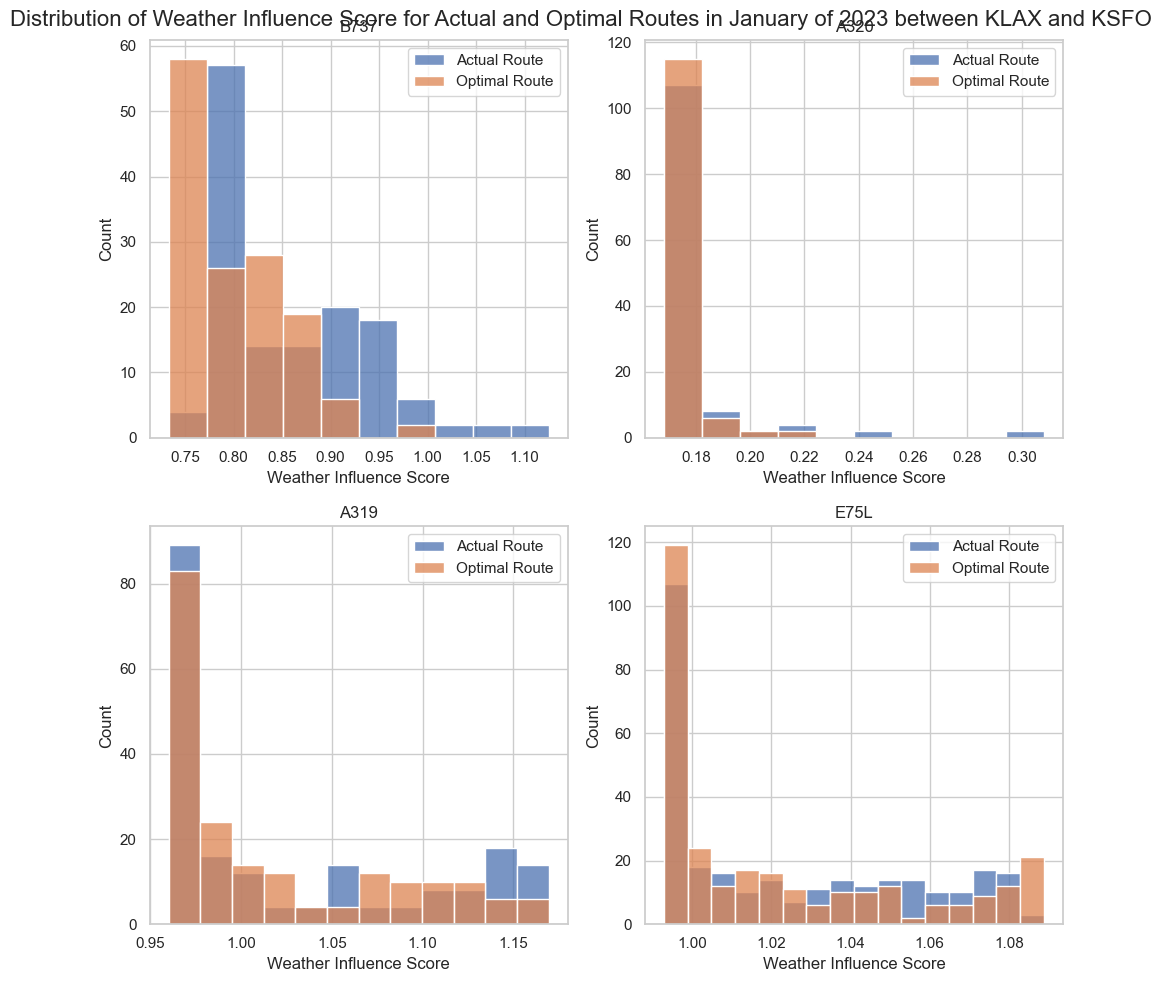

In [82]:
grid_size = math.ceil(np.sqrt(n_aircrafts))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, aircraft in enumerate(sorted_aircrafts):
    if i >= len(axes):  # In case of more aircraft types than grid cells
        break
    mask = flights['typecode'] == aircraft
    flights_aircraft = flights[mask].copy()
    minX = min([flights_aircraft['weather_influence_score'].min(), flights_aircraft['weather_influence_score_opt'].min()])
    maxX = max([flights_aircraft['weather_influence_score'].max(), flights_aircraft['weather_influence_score_opt'].max()])
    bins = np.linspace(minX, maxX, num=int(np.sqrt(len(flights_aircraft))))
#     axes[i].hist(flights_aircraft['weather_influence_score'], histtype = 'step', label = 'Actual Route', bins=bins)
#     axes[i].hist(flights_aircraft['weather_influence_score_opt'], histtype = 'step', label = 'Optimal Route', bins=bins)
    try:
        sns.histplot(flights_aircraft['weather_influence_score'], bins=bins, kde=False, label='Actual Route', ax=axes[i])
        sns.histplot(flights_aircraft['weather_influence_score_opt'], bins=bins, kde=False, label='Optimal Route', ax=axes[i])
    except:
        pass
    axes[i].legend()
    axes[i].set_xlabel('Weather Influence Score')
    axes[i].set_ylabel('Count')
    axes[i].set_title(aircraft)
    
fig.suptitle(f'Distribution of Weather Influence Score for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the global title
plt.show()
    

In [ ]:
flights['WIS_ratio'] = flights['weather_influence_score_opt']/flights['weather_influence_score']
greatest_ratio_flight_id = flights.sort_values('WIS_ratio')['flight_id'].values[-1][-1]

flights_connection = sqlite3.connect(flights_database)
state_vectors_actual = pd.read_sql_query(f"""
    SELECT *
    FROM state_vectors
    WHERE flight_id = "{greatest_ratio_flight_id}"
    """,
    flights_connection)

state_vectors_optimal = pd.read_sql_query(f"""
    SELECT sv.*
    FROM state_vectors AS sv
    INNER JOIN (
        SELECT of.flight_id
        FROM flights AS fs
        JOIN flights_aircraft AS fa ON fs.icao24 = fa.icao24
        JOIN optimal_flights AS of ON fa.typecode = of.typecode
        WHERE fs.flight_id = "{greatest_ratio_flight_id}"
    ) AS optimal_flight_id ON sv.flight_id = optimal_flight_id.flight_id;
    """,
    flights_connection)

flights_connection.close()


# state_vectors_actual
# state_vectors_optimal

In [33]:
coefficients

opt_wind             59403.865430
opt_air_density      50447.433240
opt_air_pressure     37343.003381
opt_clouds          151321.710454
opt_severity            31.384655
dtype: float64

In [ ]:
pltr = plotter.Plotter(config)